# Week2. Homework.

## Author George Chizhmak (22.09.2023).

Dataset
In this homework, we will use the California Housing Prices from Kaggle.

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

## EDA
Load the data.
Look at the median_house_value variable. Does it have a long tail?

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("./housing.csv")

<AxesSubplot:>

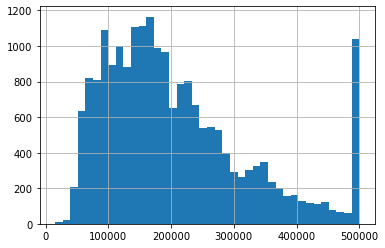

In [3]:
data['median_house_value'].hist(bins=40)

## Preparing the dataset

For this homework, we only want to use a subset of data.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Next, use only the following columns:

'latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value'

In [4]:
data = data.loc[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND']),
                ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                 'population', 'households', 'median_income', 'median_house_value']
               ]

## Question 1

There's one feature with missing values. What is it?

- total_rooms
- total_bedrooms
- population
- households

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15687 entries, 701 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            15687 non-null  float64
 1   longitude           15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


## Question 2

What's the median (50% percentile) for variable 'population'?

In [6]:
data['population'].median()

1195.0

## Prepare and split the dataset

Shuffle the dataset (the filtered one you created above), use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [7]:
np.random.seed(42)

n = len(data)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = data.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

In [8]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [9]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [10]:
# Fills missing values with 0.

X_train = df_train.fillna(0).values
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print("Option 1. RMSE train data:", round(rmse(y_train, y_pred), 2))

X_val = df_val.fillna(0).values
y_pred = w_0 + X_val.dot(w)

print("Option 1. RMSE validation data:", round(rmse(y_val, y_pred), 2))

Option 1. RMSE train data: 0.34
Option 1. RMSE validation data: 0.34


In [11]:
# Fills missing values with the mean of this variable.
mean_total_bedrooms = data['total_bedrooms'].mean()

X_train = df_train.fillna(mean_total_bedrooms).values
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

print("Option 2. RMSE train data:", round(rmse(y_train, y_pred), 2))

X_val = df_val.fillna(mean_total_bedrooms).values
y_pred = w_0 + X_val.dot(w)

print("Option 2. RMSE validation data:", round(rmse(y_val, y_pred), 2))

Option 2. RMSE train data: 0.34
Option 2. RMSE validation data: 0.34


## Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If there are multiple options, select the smallest r.

Options:

- 0
- 0.000001
- 0.001
- 0.0001

In [12]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 2))

     0 0.34
 1e-06 0.34
0.0001 0.34
 0.001 0.34
  0.01 0.34
   0.1 0.34
     1 0.34
     5 0.35
    10 0.35


In [14]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 0.3408479034179546
 1e-06 0.3408479061781977
0.0001 0.3408481800532071
 0.001 0.34085069218842706
  0.01 0.34087793005174094
   0.1 0.34128620419972316
     1 0.3448958327652975
     5 0.34773980704853946
    10 0.3483149833517472


## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [15]:
# n = len(data)
# n_val = int(0.2 * n)
# n_test = int(0.2 * n)
# n_train = n - (n_val + n_test)

def split_data_with_seed(seed=42):
    np.random.seed(seed)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = data.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    return df_train, y_train, df_val, y_val, df_test, y_test

In [16]:
scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, y_train, df_val, y_val, _, _ = split_data_with_seed(seed)
    
    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values
    
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    scores.append(rmse(y_val, y_pred))

In [17]:
np.std(scores)

0.005465718181178162

In [18]:
print(round(np.std(scores), 3))

0.005


## Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43

In [19]:
df_train, y_train, df_val, y_val, df_test, y_test = split_data_with_seed(9)
df_train_combined = pd.concat([df_train, df_val])
y_train = np.concatenate((y_train, y_val), axis=0)

X_train = df_train_combined.fillna(0).values
X_test = df_test.fillna(0).values
r = 0.001

w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
y_pred = w_0 + X_test.dot(w)

rmse(y_test, y_pred)

0.33498993366105223